# Distributed gradient methods

In [1]:
import sys; sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
from utils import create_network_of_agents, has_reached_consensus

NUM_AGENTS = 10
SEED = 42

In [2]:
def quadratic1d_fn(z, Q, r):
    val = (0.5 * Q * z**2) + (r * z)
    grad = Q * z + r
    return val, grad

## Distributed gradient algorithm

In [3]:
rng = np.random.default_rng(SEED)

Q_list = rng.uniform(size=NUM_AGENTS)
r_list = rng.normal(size=NUM_AGENTS)

z0 = rng.random((NUM_AGENTS,))


Q_all, r_all = sum(Q_list), sum(r_list)
optimal_z = -(r_all / Q_all)
optimal_cost, _ = quadratic1d_fn(optimal_z, Q_all, r_all)


_, A = create_network_of_agents(
    NUM_AGENTS,
    "doubly-stochastic",
    connected = True,
    seed = SEED
)

Consensus: True
Cost: -0.6072145517234115 | Optimal: -0.6098107818975428


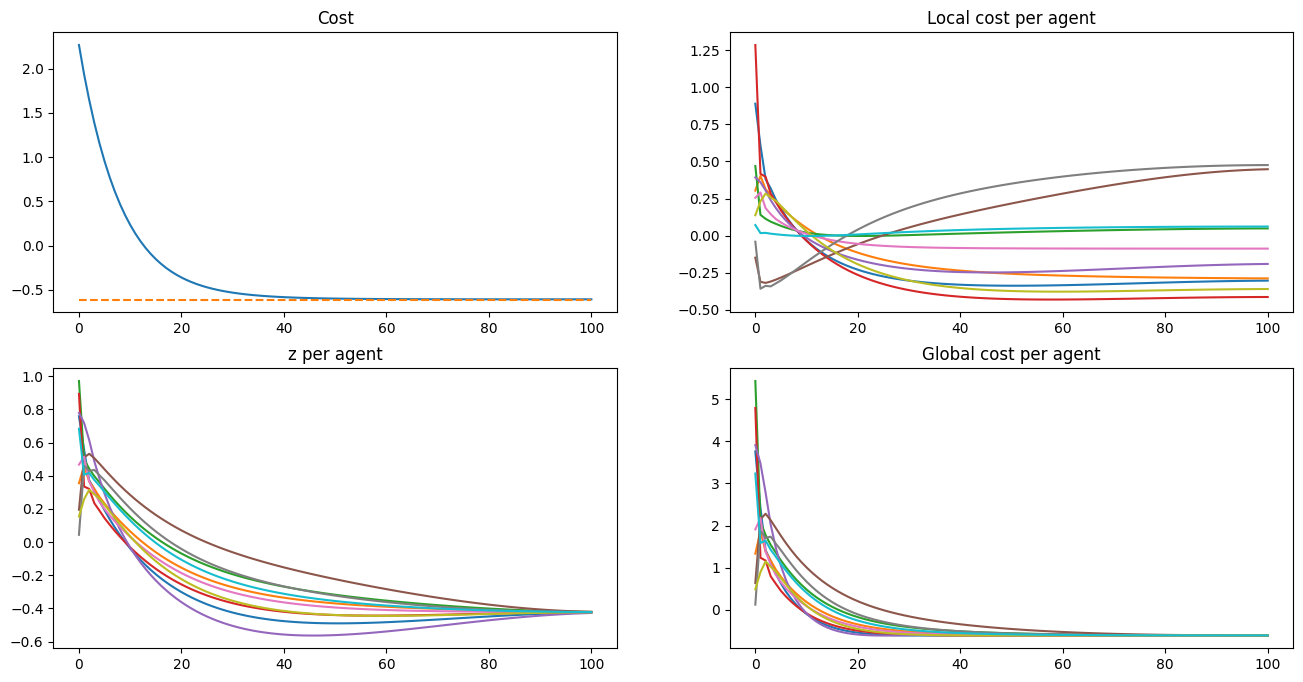

In [4]:
def schedule_constant(alpha0, k, max_iters):
    return alpha0

def schedule_linear(alpha0, k, max_iters):
    return alpha0 * (1 - (k/max_iters))

def schedule_cosine(alpha0, k, max_iters):
    return (1/2) * alpha0 * (1 + np.cos((k*np.pi) / max_iters))


def distributed_gradient_algorithm(z0, A, Q_list, r_list, alpha, num_iters, schedule_fn=schedule_constant):
    num_agents = len(Q_list)
    z = np.zeros((num_iters+1, num_agents))
    z[0] = z0
    alpha_init = alpha

    for k in range(num_iters):
        alpha = schedule_fn(alpha_init, k, num_iters)
        
        for i in range(num_agents):
            v_i = 0
            neighbors = np.nonzero(A[i])[0]
            for j in neighbors:
                v_i += A[i, j] * z[k, j]

            _, grad_i = quadratic1d_fn(v_i, Q_list[i], r_list[i])
            z[k+1, i] = v_i - alpha * grad_i 

    return z


history_z_dga = distributed_gradient_algorithm(
    z0.copy(),
    A,
    Q_list, 
    r_list, 
    num_iters = 100,
    alpha = 1e-1,
    # schedule_fn = schedule_constant
    # schedule_fn = schedule_linear
    schedule_fn = schedule_cosine
)


print(f"Consensus: {has_reached_consensus(history_z_dga[-1], tolerance=1e-2)}")
print(f"Cost: {quadratic1d_fn(history_z_dga[-1].mean(), Q_all, r_all)[0]} | Optimal: {optimal_cost}")


plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title("Cost")
# plt.plot([ sum(quadratic1d_fn(z[i], Q_list[i], r_list[i])[0] for i in range(NUM_AGENTS)) for z in history_z_dga ])
plt.plot([ quadratic1d_fn(z.mean(), Q_all, r_all)[0] for z in history_z_dga ])
plt.plot([optimal_cost]*len(history_z_dga), "--", label="Optimum")

plt.subplot(2, 2, 2)
plt.title("Local cost per agent")
for i in range(NUM_AGENTS):
    plt.plot([ quadratic1d_fn(z[i], Q_list[i], r_list[i])[0] for z in history_z_dga ], label=f"Cost agent {i}")

plt.subplot(2, 2, 3)
plt.title("z per agent")
for i in range(NUM_AGENTS):
    plt.plot([ z[i] for z in history_z_dga ], label=f"z agent {i}")

plt.subplot(2, 2, 4)
plt.title("Global cost per agent")
for i in range(NUM_AGENTS):
    plt.plot([ quadratic1d_fn(z[i], Q_all, r_all)[0] for z in history_z_dga ], label=f"Cost agent {i}")

plt.show()